In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn
import pandas as pd
import cv2
import sys
import scipy.stats as stt
from scipy.linalg import toeplitz
import re
from datetime import datetime as dt
import time
import scipy.ndimage as ndi 
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')
seaborn.set(font_scale=1.2,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.load import load_data
from mecll.proc_beh import get_all_transitions, get_transitions_state, build_poke_df, get_in_task_pokes
from mecll.proc_neural import get_all_resps, get_mean_resps
from mecll.plot.plot_activity_on_graph import plot_activity_on_graph, plot_cell

ModuleNotFoundError: No module named 'mecll.proc_beh'

In [ ]:
n_bytes = 66257620992
samples_offset = (n_bytes/2/384)

In [5]:
root_path = '/Users/yves/Downloads/example_files2_wOF/'
all_fs = os.listdir(root_path)
position = np.load(os.path.join(root_path,[i for i in os.listdir(root_path) if '_positions.npy' in i][0]))


sync_path_spk = os.path.join(root_path,[i for i in all_fs if i=='timestamps_OF.npy'][0])#'/Users/yves/Downloads/example_files/timestamps.npy'
sync_messages_spk = np.load(sync_path_spk)[::2][:-1].astype('float')


In [259]:
#process task data

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out
all_poke_dict = get_in_task_pokes(lines,events)

In [263]:
all_poke_times = []
for d_ in all_poke_dict:
    for k in d_:
        if k.isdigit():
            all_poke_times.extend(d_[k])

In [15]:

#load spiking data
#ROOT = '/Users/yves/Downloads/example_files/'
spkT = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_times.npy'][0])).flatten()
spkC = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_clusters.npy'][0])).flatten()
cluster_labels = pd.read_table(os.path.join(root_path,[i for i in all_fs if '.tsv' in i][0]))


#select single units
single_units = np.where(cluster_labels.KSLabel=='good')[0]

In [16]:
import scipy as sp
import scipy.signal

In [18]:
cam_sync_path = os.path.join(root_path,[i for i in all_fs if ('OFB' in i and 'pinstate' in i)][0])
sync_df = pd.read_csv(cam_sync_path,header=None)
sync_messages_cam = np.where((sync_df[0].values[1:] - sync_df[0].values[:-1])<0)[0].astype('float')

In [19]:
len(sync_messages_cam)

429

In [20]:
len(sync_messages_spk)

429

In [21]:
#+86272944
aligner = Rsync_aligner(sync_messages_spk+samples_offset,sync_messages_cam,units_A=30/30000.,units_B=1)

In [22]:
single_units = np.where(cluster_labels.KSLabel=='good')[0]

In [283]:
def build_spike_array_direct(spkC,spkT,bin_size=10,sample_rate=30000,start=0,end=10**16,window_times=None,window_size=30000):
    #maybe use sparse matrix here...
    
    n_bins_total = int(np.ceil((np.max(spkT)/30000) * (1000/bin_size)))
    n_cells_total = len(np.unique(spkC))
    spkT2 = np.floor((spkT / 30000) * (1000/bin_size)).astype('int')
    cell_array = np.zeros([n_cells_total,n_bins_total])
    
    start_bins = np.floor((start/30000) * (1000/bin_size)).astype('int')
    end_bins = np.floor((end/30000) * (1000/bin_size)).astype('int')
    print(start_bins,end_bins,cell_array.shape)
    for cell_ctr,cell_ix in enumerate(np.unique(spkC)):
        
        if window_times is None:
            spk_inds = np.where(np.logical_and(spkC==cell_ix,
                                              np.logical_and(spkT>start,spkT<end)))[0]
        else:
            spk_inds = np.where(np.logical_and.reduce([spkC==cell_ix,
                                                       np.logical_and(spkT>start,spkT<end),
                                                       np.any((spkT-window_times[:,None])<window_size,axis=1)]
                                                     ))[0]

        t_,c = np.unique(spkT2[spk_inds],return_counts=True)
        cell_array[cell_ctr,t_] = c
    return cell_array[:,start_bins:end_bins]
        
    

In [122]:
from mecll.GLM import logL,grad,hess, logL_prior, grad_prior, hess_prior
import scipy.optimize as op

def logL_prior(beta,x,y,p_mu,p_cov,p_covInv):
    rate = np.exp(np.dot(beta,x))
    LL = np.sum(y*np.log(rate)-rate)


    LL_prior = (-.5*((aa[1:]-p_mu).dot(p_covInv).dot(aa[1:]-p_mu)) 
                - .5*np.abs(np.linalg.slogdet(p_covInv)[1]) 
                - .5*(p_covInv.shape[0]-1)*np.log((2*np.pi))
                )
    return -(LL+LL_prior)

In [375]:
def build_mask_array(cell_array,event_times,bin_size=10,sample_rate=30000.,start=0,end=10**16):
    
    mask = np.zeros_like(cell_array[0])
    bin_size=10
    apt_binned = np.floor((apt/sample_rate) * (1000/bin_size)).astype('int')
    mask[apt_binned] = 1
    mask = np.convolve(np.ones(200),mask)>0
    return mask
    

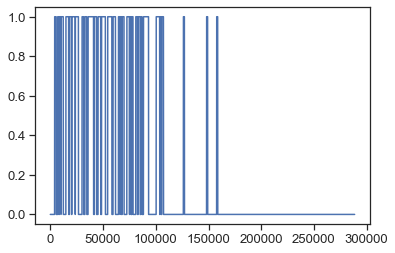

In [378]:
plt.plot(mask_array)

In [379]:
len(mask_array)

288575

In [380]:
cell_array1.shape

(784, 67261)

In [381]:
n_back = 5
#= toeplitz(np.arange(n_back),arr2)[:,n_back:-n_back]


In [382]:
grid_cell_list = [148,132,134,113,123,267,275]


In [383]:
cell_array[grid_cell_list[1]].sum()

56865.0

In [384]:
cell_array1_backup = build_spike_array_direct(spkC,spkT,bin_size=10,sample_rate=30000,end=samples_offset)
cell_array1 = cell_array1_backup.copy()

0 287576 (784, 501194)


In [385]:
grid_cell_list = [148,132,134,113,123,267,275]


In [386]:
#grid_cell_list = np.random.randint(0,275,7)

In [387]:
apt = aligner.B_to_A(all_poke_times)
mask_array = build_mask_array(cell_array1,apt)

In [388]:
np.mean(mask_array)

0.08727304317609243

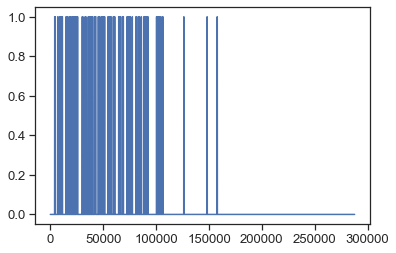

In [389]:
plt.plot(mask_array)

In [390]:
mask_array.shape

(287775,)

In [391]:
cell_array1.shape

(784, 287576)

In [392]:
np.concatenate([[0],mask_array])

array([0, 0, 0, ..., 0, 0, 0])

In [393]:
cell_array1 = cell_array1[:,np.where(np.concatenate([[0],mask_array]))[0]]
print(mask_array.shape,cell_array1.shape)

(287775,) (784, 25115)


In [394]:
n_neurons = len(grid_cell_list) #cell_array.shape[0]
res_store = []

p_cov = 10*np.eye(n_back+2-1)
p_covInv = np.linalg.inv(p_cov)
for cell_ix,cell_y in enumerate(grid_cell_list):
    sys.stdout.write('\rrunning {}/{}'.format(cell_ix+1,n_neurons))
    sys.stdout.flush()
    for cell_x in grid_cell_list:
     
        arr2 = np.concatenate([np.zeros(n_back),cell_array1[cell_x],np.zeros(n_back)])
        arr3 = toeplitz(np.arange(n_back),arr2)[:,n_back:-n_back]

        DM = np.vstack([np.ones_like(cell_array1[0]),np.mean(np.delete(cell_array1.copy(),cell_y,axis=0),axis=0),arr3])
        DM[1:] = stt.zscore(DM[1:],axis=1)
        spk = cell_array1[cell_y]
        res = op.minimize(logL_prior,
                   [0]*DM.shape[0],
                   args=(DM,spk,np.zeros(n_back+2-1),p_cov,p_covInv),
                   method='Newton-CG',
                   jac=grad_prior,
                   hess=hess_prior)
        

        res_store.append(res.x)

running 7/7

In [396]:
cell_array2 = build_spike_array_direct(spkC,spkT,bin_size=10,sample_rate=30000,start=samples_offset)

287576 33333333333333 (784, 501194)


In [397]:
n_neurons = len(grid_cell_list) #cell_array.shape[0]
res_store2 = []
for cell_ix,cell_y in enumerate(grid_cell_list):
    sys.stdout.write('\rrunning {}/{}'.format(cell_ix+1,n_neurons))
    sys.stdout.flush()
    for cell_x in grid_cell_list:
     
        arr2 = np.concatenate([np.zeros(n_back),cell_array2[cell_x],np.zeros(n_back)])
        arr3 = toeplitz(np.arange(n_back),arr2)[:,n_back:-n_back]

        DM = np.vstack([np.ones_like(cell_array2[0]),np.mean(np.delete(cell_array2.copy(),cell_y,axis=0),axis=0),arr3])
        DM[1:] = stt.zscore(DM[1:],axis=1)
        spk = cell_array2[cell_y]
        res = op.minimize(logL_prior,
                   [0]*DM.shape[0],
                   args=(DM,spk,np.zeros(n_back+2-1),p_cov,p_covInv),
                   method='Newton-CG',
                   jac=grad_prior,
                   hess=hess_prior)
        
        

        res_store2.append(res.x)

running 7/7

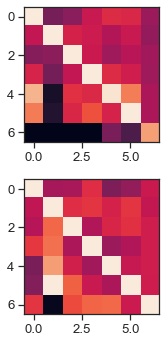

In [400]:
plt.figure(figsize=(12,5))

plt.subplot(2,1,1)
corr_mtx1 = np.array(res_store)[:,2].reshape(n_neurons,n_neurons)
#corr_mtx1[np.diag_indices_from(corr_mtx1)] = 0
plt.imshow(corr_mtx1,vmin=-.2,vmax=.2)

plt.subplot(2,1,2)
corr_mtx2 = np.array(res_store2)[:,2].reshape(n_neurons,n_neurons)
#corr_mtx2[np.diag_indices_from(corr_mtx2)] = 0
plt.imshow(corr_mtx2,vmin=-.2,vmax=.2)

plt.tight_layout()

In [399]:
np.corrcoef(corr_mtx1.flatten(),corr_mtx2.flatten())[0,1]

0.016185348697800625

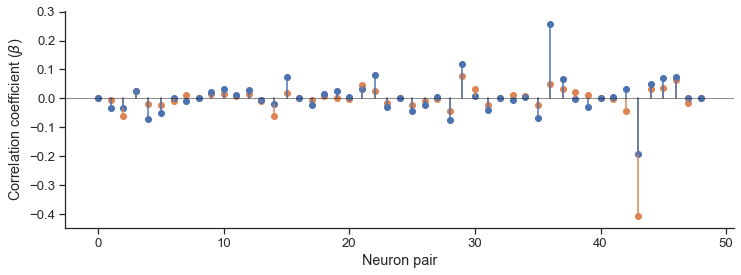

In [256]:
plt.figure(figsize=(12,4))
clrs = seaborn.color_palette(n_colors=8)

for ctr,cc in enumerate(corr_mtx1.flatten()):
    plt.plot([ctr,ctr],[0,cc],color=clrs[1])
    plt.scatter([ctr],[cc],color=clrs[1])


for ctr,cc in enumerate(corr_mtx2.flatten()):
    plt.plot([ctr,ctr],[0,cc],color=clrs[0])
    plt.scatter([ctr],[cc],color=clrs[0])

plt.axhline(y=0,color='k',linewidth=.5)
#plt.plot(corr_mtx1.flatten())
plt.xlabel("Neuron pair")
plt.ylabel(r"Correlation coefficient ($\beta$)")
seaborn.despine()